In [1]:
import torch
import numpy as np

import pandas as pd
import matplotlib.pyplot as plt

from torchvision.models import alexnet
from torchvision.transforms import Compose, ToTensor, Resize, Grayscale
from torch.utils.data import DataLoader
from PytorchStorage import ForwardModuleStorage
from sklearn.cluster import KMeans
from tqdm import tqdm_notebook as tqdm
from collections import OrderedDict

In [2]:
%matplotlib notebook

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [4]:
def pca(x, k=2):
    """
    From http://agnesmustar.com/2017/11/01/principal-component-analysis-pca-implemented-pytorch/
    """
    # preprocess the data
    X_mean = torch.mean(x,0)
    x = x - X_mean.expand_as(x)
    # svd
    U,S,V = torch.svd(torch.t(x))
    return torch.mm(x,U[:,:k])

## Model

## Dataset

In [5]:
from torchvision.datasets import MNIST
from fastai.vision import *

tr = Compose([Grayscale(), ToTensor()])

ds = MNIST(root='~/Documents/datasets/', download=True, transform=tr)
dl = DataLoader(ds, num_workers=14, batch_size=128, shuffle=True)

data = ImageDataBunch(dl, dl)

In [29]:
from fastai.vision import *
from fastai.layers import CrossEntropyFlat

model = simple_cnn((1,16,16,10))

learn = Learner(data, model, path='./', loss_func=CrossEntropyFlat())
learn.metrics=[accuracy]
learn.fit(10)
learn.save('learn', return_path=True)

epoch,train_loss,valid_loss,accuracy,time
0,0.631087,0.711953,0.779233,00:07
1,0.444008,0.517651,0.843750,00:08
2,0.360323,0.401535,0.881167,00:09
3,0.311501,0.335125,0.901533,00:08
4,0.277016,0.292050,0.914833,00:08
5,0.251777,0.265291,0.922533,00:09
6,0.232754,0.243148,0.929417,00:08
7,0.216887,0.226969,0.934483,00:08
8,0.204598,0.215409,0.937067,00:09
9,0.194118,0.210447,0.938017,00:09


PosixPath('models/learn.pth')

In [30]:
learn.load('./learn')

learn.validate(metrics=[accuracy])

[0.21044749, tensor(0.9380)]

In [20]:
def tensor2numpy(*args):
    return [e.cpu().numpy() for e in args]

In [55]:
import pandas as pd
from dataclasses import dataclass

@dataclass
class State():
    points: torch.tensor = torch.empty(0)
    y: torch.tensor = torch.empty(0).long()
    
    @property
    def indeces(self):
        return np.arange(len(self.pca))
    
    def __repr__(self):
        return f"points={self.points.shape}"
class ModulePCA():
    """
    Apply and visualize PCA with k-features of a specific CNN-layer. 
    It computes the PCA values batch-wise to reduce memory usage and increase performance.
    """
    def __init__(self, module, layer, dataloader):
        self.module, self.layer = module, layer
        self.storage = ForwardModuleStorage(module, [layer])
        self.dataloader = dataloader
        self.ax2d = plt.subplot(111)
        self.state = State()
        
    def points(self, dataloader, k=2, n_batches=None):
        """
        Batch-wise PCA. It returns the pca points, the labels and the inputs as Pytorch Tensors.
        """
        for i, (x, y) in enumerate(dataloader):
            y, x = y.to(device), x.to(device)
            self.storage(x) # run input into the storage
            with torch.no_grad():
                features = self.storage[self.layer][0]
                flat_features = features.view(features.shape[0], -1)
                pca_features = pca(flat_features, k=k)
                del self.storage.state[self.layer] # reinit storage -> save memory
                self.storage.state[self.layer] = []
                if n_batches is not None and i == n_batches: break
                yield pca_features, y, x
    
    def __call__(self, *args, **kwargs):
        for points, y, x in tqdm(self.points(self.dataloader, *args, **kwargs)):
            # store points and labels by bringing them to the cpu to save GPU memory
            self.state.points = torch.cat([self.state.points, points.cpu()])
            self.state.y = torch.cat([self.state.y, y.cpu()])

        return self
    
    def reduce(self, to=100):
        kmeans = KMeans(n_clusters=to)
        kmeans.fit(module_pca.state.points.numpy(), y=module_pca.state.y.numpy())
        
        points = kmeans.cluster_centers_
        y = np.array([module_pca.state.y.numpy()[np.where(kmeans.labels_ == i)][0] for i in range(kmeans.n_clusters)])
        
        reduced_mmodule_pca =  ModulePCA(self.module, self.layer, self.dataloader)
        reduced_mmodule_pca.state = State(torch.from_numpy(points), torch.from_numpy(y))
        
        return reduced_mmodule_pca
    
    def plot2d(self):
        fig = plt.figure()
        title = f"{len(self.state.points)} points"
        points, y = tensor2numpy(self.state.points, self.state.y)
        for i, label in enumerate(np.unique(y).tolist()):
                self.ax2d.scatter(points[y == i, 0], points[y == i, 1], label=label)
        handles, labels = self.ax2d.get_legend_handles_labels()
        by_label = OrderedDict(zip(labels, handles))
        self.ax2d.legend(by_label.values(), by_label.keys())
        plt.title(title)
        return fig

/home/francesco/anaconda3/envs/dl/lib/python3.7/site-packages/ipykernel_launcher.py:24: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


<IPython.core.display.Javascript object>


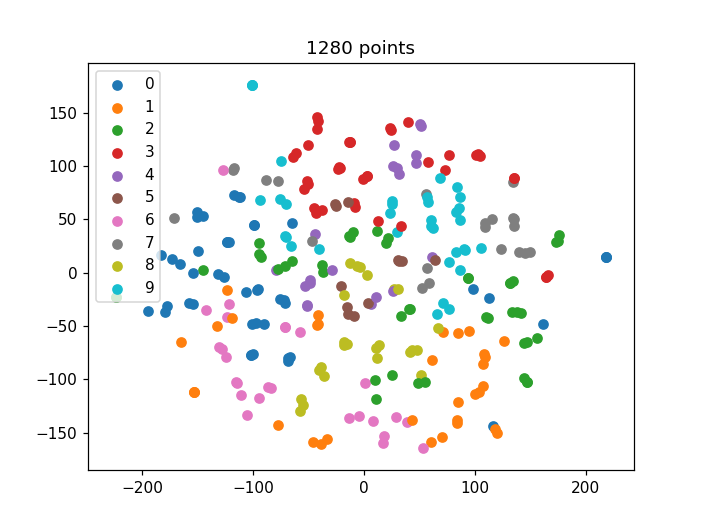

In [56]:
module_pca = ModulePCA(learn.model, learn.model[2][0], learn.data.train_dl)
module_pca(k=2, n_batches=10)
module_pca.plot2d().show()

/home/francesco/anaconda3/envs/dl/lib/python3.7/site-packages/ipykernel_launcher.py:24: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


<IPython.core.display.Javascript object>


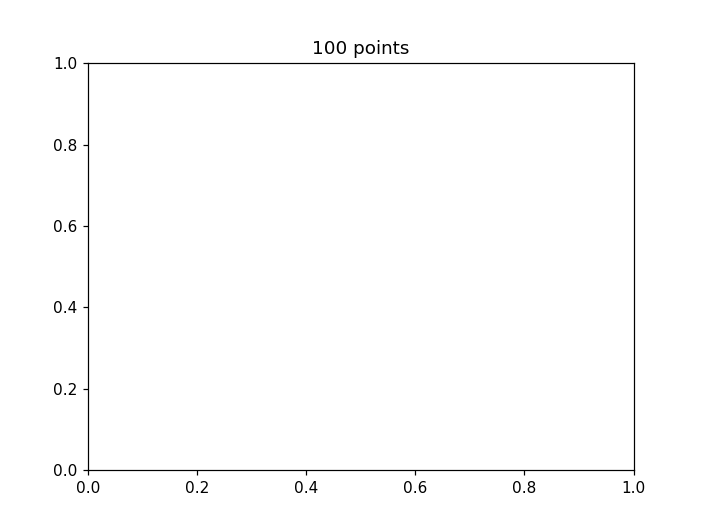

In [59]:
module_pca.reduce(100).plot2d().show()